In [13]:
import pandas as pd
import tkinter as tk
from tkinter import ttk, filedialog, messagebox
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from datetime import datetime


In [14]:
# Funktion: CSV-Datei laden
def csv_laden():
    # globale variable daten
    global daten

    # dateipfad wird sichergestellt - CSV wählen
    dateipfad = filedialog.askopenfilename(filetypes=[("CSV Dateien", "*.csv")])
    if not dateipfad:
        return

    # Einen Panda dataFrame erstellen
    # Spalten auf existenz prüfen
    # Daten vorbereiten
    try:
        daten = pd.read_csv(dateipfad, sep=";", engine='python', decimal=',', encoding='utf-8-sig')

        benoetigte_spalten = [
            'Energieträger', 'Betriebs-Status', 'Bruttoleistung der Einheit',
            'Inbetriebnahmedatum der Einheit', 'Datum der geplanten Inbetriebnahme',
            'Datum der endgültigen Stilllegung', 'Technologie der Stromerzeugung',
            'Speichertechnologie', 'Wind an Land oder auf See', 'Art der Solaranlage',
            'Art der Bodenfläche (der PV-Anlage)', 'Ort', 'Gemeinde', 'Landkreis'
        ]
        fehlend = [spalte for spalte in benoetigte_spalten if spalte not in daten.columns]
        if fehlend:
            messagebox.showerror("Fehler", f"Fehlende Spalten: {', '.join(fehlend)}")
            return
        
        # Bruttoleistung in MW umrechnen
        daten['Bruttoleistung der Einheit'] = pd.to_numeric(daten['Bruttoleistung der Einheit'], errors='coerce') / 1000

        # Lage, Technologie, Datumsspalte Planung, DatumAnalyse und daten, als Kombispalte erstellen
        lage_spalten = ['Wind an Land oder auf See', 'Art der Solaranlage', 'Art der Bodenfläche (der PV-Anlage)']
        daten['Lage'] = daten[lage_spalten].bfill(axis=1).iloc[:, 0]

        daten['Technologie'] = daten[['Technologie der Stromerzeugung', 'Speichertechnologie']].bfill(axis=1).iloc[:, 0]

        # Planungsspalte füllen nach vorhandenen Datum
        daten['Planung'] = None
        daten.loc[daten["Betriebs-Status"] == "In Planung", "Planung"] = daten[
            ['Datum der geplanten Inbetriebnahme', 'Inbetriebnahmedatum der Einheit']].bfill(axis=1).iloc[:, 0]

        # DatumAnalyse füllen nach Betriebs-Status
        daten["DatumAnalyse"] = pd.NaT
        daten.loc[daten["Betriebs-Status"] == "In Betrieb", "DatumAnalyse"] = daten["Inbetriebnahmedatum der Einheit"]
        daten.loc[daten["Betriebs-Status"] == "Endgültig stillgelegt", "DatumAnalyse"] = daten["Datum der endgültigen Stilllegung"]
        daten.loc[daten["Betriebs-Status"] == "Vorübergehend stillgelegt", "DatumAnalyse"] = daten["Inbetriebnahmedatum der Einheit"]
        daten.loc[daten["Betriebs-Status"] == "In Planung", "DatumAnalyse"] = daten["Planung"]

        # Doppelte Einträge löschen, Datumsformat prüfen
        daten = daten.drop_duplicates(subset=["MaStR-Nr. der Einheit"])
        daten["DatumAnalyse"] = pd.to_datetime(daten["DatumAnalyse"], format="%d.%m.%Y", errors="coerce")
        daten["Jahr"] = daten["DatumAnalyse"].dt.year
        daten["Monat"] = daten["DatumAnalyse"].dt.month_name(locale='de_DE')

        # Dropdown-Menüs füllen und defaultwert setzen
        energietraeger_dropdown["values"] = ["Alle"] + sorted(daten['Energieträger'].dropna().unique().tolist())
        energietraeger_var.set("Alle")

        betriebsstatus_dropdown["values"] = ["Alle"] + sorted(daten['Betriebs-Status'].dropna().unique().tolist())
        betriebsstatus_var.set("Alle")

        lage_dropdown["values"] = ["Alle"] + sorted(daten['Lage'].dropna().unique().tolist())
        lage_var.set("Alle")

        technologie_dropdown["values"] = ["Alle"] + sorted(daten['Technologie'].dropna().unique().tolist())
        technologie_var.set("Alle")

        # daten_filtern funktionsaufruf
        daten_filtern()

    except Exception as fehler:
        messagebox.showerror("Fehler", f"Fehler beim Laden der Datei: {fehler}")

In [15]:
# Funktion, um die Daten basierend auf Filtern zu aktualisieren

def daten_filtern(event=None):
    try:
        if daten is None or daten.empty:
            messagebox.showerror("Fehler", "Keine Daten geladen.")
            return

        # UI-Elemente einblenden
        jahr_von_label.grid()
        jahr_von_entry.grid()
        jahr_bis_label.grid()
        jahr_bis_entry.grid()
        bestätigen_button.grid()
        info_label.grid()
        
        # defaultwert
        attribut = "Energieträger"
        chart_type = "barh"

        # Auslesen der Dropdown und Felder, Kopie von modify dataframe
        selected_energietraeger = energietraeger_var.get()
        selected_betriebsstatus = betriebsstatus_var.get()
        selected_lage = lage_var.get()
        selected_technologie = technologie_var.get()
        jahr_von = jahr_von_var.get().strip()
        jahr_bis = jahr_bis_var.get().strip()

        gefilterte_Daten = daten.copy()

        # entfernt leere Datensätze in DatumAnalyse
        gueltige_daten = daten["DatumAnalyse"].dropna()

        # legt max und min Jahr fest
        min_jahr = gueltige_daten.min().year
        max_jahr = gueltige_daten.max().year

        # Jahres-Eingabe auf int, max und min Wert prüfen
        def prüfe_jahr(eingabe, name):
            if eingabe:
                try:
                    wert = int(eingabe)
                    if wert < min_jahr or wert > max_jahr:
                        raise ValueError
                    return wert
                except ValueError:
                    messagebox.showerror("Fehler", f"'{name}' muss eine Zahl zwischen {min_jahr} und {max_jahr} sein.")
                    return None
            return None

        jahr_von_int = prüfe_jahr(jahr_von, "Jahr von")
        jahr_bis_int = prüfe_jahr(jahr_bis, "Jahr bis")
        if jahr_von and jahr_von_int is None or jahr_bis and jahr_bis_int is None:
            return

        # Filterlogik, Monat oder Jahr-Auswertung
        if jahr_von_int and jahr_bis_int:
            if jahr_von_int > jahr_bis_int:
                jahr_von_int, jahr_bis_int = jahr_bis_int, jahr_von_int
                jahr_von_var.set(str(jahr_von_int))
                jahr_bis_var.set(str(jahr_bis_int))
                messagebox.showinfo("Hinweis", "Werte für 'Jahr von/bis' wurden getauscht.")
            gefilterte_Daten = gefilterte_Daten[
                (gefilterte_Daten["Jahr"] >= jahr_von_int) & (gefilterte_Daten["Jahr"] <= jahr_bis_int)]
            attribut = "Jahr"
            chart_type = "bar"

        elif jahr_von_int or jahr_bis_int:
            jahr = jahr_von_int or jahr_bis_int
            gefilterte_Daten = gefilterte_Daten[gefilterte_Daten["Jahr"] == jahr]
            attribut = "Monat"
            chart_type = "bar"

        if jahr_von and jahr_bis:
            jahresinfo = f"{jahr_von}–{jahr_bis}"
        elif jahr_von:
            jahresinfo = f"{jahr_von}"
        else:
            jahresinfo = "alle Jahre"

        # Weitere Filter
        if selected_energietraeger != "Alle":
            gefilterte_Daten = gefilterte_Daten[gefilterte_Daten["Energieträger"] == selected_energietraeger]
        if selected_betriebsstatus != "Alle":
            gefilterte_Daten = gefilterte_Daten[gefilterte_Daten["Betriebs-Status"] == selected_betriebsstatus]
        if selected_lage != "Alle":
            gefilterte_Daten = gefilterte_Daten[gefilterte_Daten["Lage"] == selected_lage]
        if selected_technologie != "Alle":
            gefilterte_Daten = gefilterte_Daten[gefilterte_Daten["Technologie"] == selected_technologie]

        # Zeitspalten nachberechnen
        gefilterte_Daten = gefilterte_Daten.dropna(subset=["DatumAnalyse"])
        gefilterte_Daten["Jahr"] = gefilterte_Daten["DatumAnalyse"].dt.year
        gefilterte_Daten["Monat"] = gefilterte_Daten["DatumAnalyse"].dt.month_name(locale='de_DE')

        # Leere Ergebnisse
        if gefilterte_Daten.empty:
            output_text.set("Keine Daten gefunden.")
            diagramm("Energieträger", "barh", "Zubau der Bruttoleistung (MW)", "Energieträger", "Keine Daten", pd.DataFrame(), pd.Series())
            return

        # Beschreibungstext erstellen
        beschreibung = "Gefiltert: " if any(v != "Alle" for v in [selected_energietraeger, selected_betriebsstatus, selected_lage, selected_technologie]) else "Gesamtübersicht"
        beschreibung += f" {selected_energietraeger if selected_energietraeger != 'Alle' else ''} {selected_betriebsstatus if selected_betriebsstatus != 'Alle' else ''} {selected_lage if selected_lage != 'Alle' else ''} {selected_technologie if selected_technologie != 'Alle' else ''}"
        output_text.set(beschreibung.strip())

        # Gesamtdaten = Kopie von modify dataframe
        # löscht Zeilen in den Dateb fehlen
        # erstell neue Spalten und jahre und monate
        gesamtdaten = daten.copy()
        gesamtdaten = gesamtdaten.dropna(subset=["DatumAnalyse"])
        gesamtdaten["Jahr"] = gesamtdaten["DatumAnalyse"].dt.year
        gesamtdaten["Monat"] = gesamtdaten["DatumAnalyse"].dt.month_name(locale='de_DE')

        if selected_energietraeger != "Alle":
            gesamtdaten = gesamtdaten[gesamtdaten["Energieträger"] == selected_energietraeger]
        if selected_betriebsstatus != "Alle":
            gesamtdaten = gesamtdaten[gesamtdaten["Betriebs-Status"] == selected_betriebsstatus]
        if selected_lage != "Alle":
            gesamtdaten = gesamtdaten[gesamtdaten["Lage"] == selected_lage]
        if selected_technologie != "Alle":
            gesamtdaten = gesamtdaten[gesamtdaten["Technologie"] == selected_technologie]

        # Summierung der Bruttoleistung
        if attribut == "Monat":
            jahr = jahr_von_int or jahr_bis_int
            gesamtdaten = gesamtdaten[gesamtdaten["Jahr"] == jahr]
            daten_summiert = gesamtdaten.groupby("Monat")["Bruttoleistung der Einheit"].sum()
        elif attribut == "Jahr":
            gesamtdaten = gesamtdaten[(gesamtdaten["Jahr"] >= jahr_von_int) & (gesamtdaten["Jahr"] <= jahr_bis_int)]
            daten_summiert = gesamtdaten.groupby("Jahr")["Bruttoleistung der Einheit"].sum()
        else:
            daten_summiert = gesamtdaten.groupby(attribut)["Bruttoleistung der Einheit"].sum()

        # Diagramm Funktionsaufruf
        diagramm(
            attribut,
            chart_type,
            "Jahr" if attribut == "Jahr" else ("Monat" if attribut == "Monat" else "Bruttoleistung (MW)"),
            "Summe der Bruttoleistung (MW)" if attribut in ["Jahr", "Monat"] else "Energieträger",
            f"Zubau Bruttoleistung {attribut} in (MW) ({jahresinfo})",
            gefilterte_Daten,
            daten_summiert
        )

    except Exception as e:
        messagebox.showerror("Fehler", f"Filterfehler: {e}")
        print(f"[ERROR] daten_filtern(): {e}")


In [ ]:
# Funktion, um ein Diagramm zu erstellen
def diagramm(attribut, chart_type, xlabel, ylabel, title, gefilterte_Daten, daten_summiert):
    

    try:
        # gefilterte_Daten prüfen, ob Dateninhalt 
        if gefilterte_Daten.empty:
            output_text.set("Keine Daten gefunden.")

            fig, ax = plt.subplots(figsize=(10, 6))
            ax.text(0.5, 0.5, 'Keine Daten verfügbar', fontsize=14, ha='center', va='center')
            ax.axis('off')

            for widget in chart_frame.winfo_children():
                widget.destroy()

            canvas = FigureCanvasTkAgg(fig, master=chart_frame)
            canvas.draw()
            canvas.get_tk_widget().pack()

            rohdaten_label.config(text="Keine Rohdaten verfügbar.")
            return

        # Standort-Infos
        standort_info = []
        if "Ort" in gefilterte_Daten.columns and not gefilterte_Daten["Ort"].dropna().empty:
            standort_info.append("Ort(e): " + ", ".join(gefilterte_Daten["Ort"].dropna().unique()))
        if "Gemeinde" in gefilterte_Daten.columns and not gefilterte_Daten["Gemeinde"].dropna().empty:
            standort_info.append("Gemeinde(n): " + ", ".join(gefilterte_Daten["Gemeinde"].dropna().unique()))
        if "Landkreis" in gefilterte_Daten.columns and not gefilterte_Daten["Landkreis"].dropna().empty:
            standort_info.append("Landkreis(e): " + ", ".join(gefilterte_Daten["Landkreis"].dropna().unique()))
        if not standort_info:
            standort_info.append("Standort: Unbekannt")

        # Monatsnamen Array
        MONATSNAMEN = [
            "Januar", "Februar", "März", "April", "Mai", "Juni",
            "Juli", "August", "September", "Oktober", "November", "Dezember"
        ]

        # Diagramm größe festlegen 
        fig, ax = plt.subplots(figsize=(10, 6))

        # Energieträger = Alle und Filterung nach Jahr/Monat
        energietraeger_alle = energietraeger_var.get() == "Alle"

        # Diagramm mit nebeneinader stehenden Balken für Energieträger == Alle + Jahr/Monat 
        if energietraeger_alle and attribut in ["Jahr", "Monat"]:
            # Pivot-Tabelle: Energieträger (Spalten) pro Jahr/Monat (Zeilen), summiere Bruttoleistung
            pivot = gefilterte_Daten.pivot_table(
                index=attribut,
                columns="Energieträger",
                values="Bruttoleistung der Einheit",
                aggfunc="sum",
                fill_value=0
            )

            # Monatsreihenfolge erzwingen (falls Monatsausgabe)
            if attribut == "Monat":
                pivot = pivot.reindex(MONATSNAMEN).dropna(how='all')

            # Achsen vorbereiten
            jahre_oder_monate = pivot.index  # x-Achse: Jahr oder Monat
            energietraeger = pivot.columns  # Balken: Energieträger
            x = np.arange(len(jahre_oder_monate))  # Positionen auf x-Achse
            breite = 0.8 / len(energietraeger)     # Balkenbreite (angepasst für mehrere Energieträger)

            # Mehrere Balken nebeneinander zeichnen (für jeden Energieträger)
            for idx, et in enumerate(energietraeger):
                ax.bar(x + idx * breite, pivot[et], width=breite, label=et)

            # X-Achse anpassen
            ax.set_xticks(x + breite * (len(energietraeger)-1) / 2)
            ax.set_xticklabels(jahre_oder_monate)
            ax.legend(title="Energieträger")

        # Diagramm für normale für Energieträger != Alle + Jahr/Monat 
        else:
            if attribut == "Jahr":
                # Jahresausgabe: Summiere Bruttoleistung pro Jahr
                attribut_counts = gefilterte_Daten.groupby("Jahr")["Bruttoleistung der Einheit"].sum().sort_index()
            elif attribut == "Monat":
                # Monatliche Ausgabe: Sortiere nach Monat
                attribut_counts = gefilterte_Daten.groupby("Monat")["Bruttoleistung der Einheit"].sum()
                attribut_counts = attribut_counts.reindex(MONATSNAMEN).dropna()
            else:
                # Energieträger-Übersicht
                attribut_counts = gefilterte_Daten.groupby("Energieträger")["Bruttoleistung der Einheit"].sum().sort_values(ascending=False)

            if len(attribut_counts) > 0:
                colors = plt.cm.viridis(np.linspace(0, 1, len(attribut_counts)))
            else:
                colors = ["#FF0000"]  # Wenn keine Daten vorhanden sind

            # Balkendiagramm vertikal oder horizontal
            if chart_type == "bar":
                ax.bar(
                    attribut_counts.index.astype(str),
                    attribut_counts.values,
                )
                for i, (name, value) in enumerate(attribut_counts.items()):
                    ax.bar(name, value, color=colors[i], label=name)

                ax.legend(title="Energieträger", loc="upper right", fontsize=9, title_fontsize=10)

            elif chart_type == "barh":
                ax.barh(
                    attribut_counts.index.astype(str),
                    attribut_counts.values,
                )
                for i, (name, value) in enumerate(attribut_counts.items()):
                    ax.barh(name, value, color=colors[i], label=name)
                    
                ax.legend(title="Energieträger", loc="upper right", fontsize=9, title_fontsize=10)
            else:
                messagebox.showerror("Fehler", "Ungültiger Diagrammtyp.")
                return

        # Achsenbeschriftungen und Layout
        ax.set_xlabel(xlabel, fontsize=10)
        ax.set_ylabel(ylabel, fontsize=10)
        ax.set_title(title, fontsize=12)
        ax.grid(axis='y', linestyle='--', alpha=0.5)
        fig.tight_layout()

        # Vorherige Inhalte löschen
        for widget in chart_frame.winfo_children():
            widget.destroy()

        # Neues Diagramm
        canvas = FigureCanvasTkAgg(fig, master=chart_frame)
        canvas.draw()
        canvas.get_tk_widget().pack()

        # Standorttext aktualisieren
        rohdaten_label.config(text="\n".join(standort_info))

        # Tabelle erstellen 
        try:
            if 'tabelle' in globals() and tabelle.winfo_exists():
                tabelle.destroy()
        except:
            pass

        for widget in table_frame.winfo_children():
            try:
                if widget.winfo_exists():
                    widget.destroy()
            except:
                continue

        tabelle = ttk.Treeview(table_frame, columns=("beschreibung", "gesamt", "auswahl"), show="headings", height=10)
        tabelle.heading("beschreibung", text=attribut)
        tabelle.heading("gesamt", text="Gesamt Energieträger (MW)")

        # Dynamischen Filter-Text erstellen
        filter_parts = []
        if energietraeger_var.get() != "Alle":
            filter_parts.append(energietraeger_var.get())
        if betriebsstatus_var.get() != "Alle":
            filter_parts.append(betriebsstatus_var.get())
        if lage_var.get() != "Alle":
            filter_parts.append(lage_var.get())
        if technologie_var.get() != "Alle":
            filter_parts.append(technologie_var.get())

        filter_text = "Alle" if not filter_parts else " / ".join(filter_parts)

        tabelle.heading("auswahl", text=f"Gesamt ({filter_text}) (MW)")

        tabelle.column("beschreibung", anchor="center", width=150)
        tabelle.column("gesamt", anchor="center", width=150)
        tabelle.column("auswahl", anchor="center", width=200)

        # Datensätze für Tabelle
        # Nur Werte im aktuell ausgewählten Zeitraum berücksichtigen
        #Alle Daten nur nach Zeitraum filtern, KEINE Dropdown-Filter
        alle_daten = daten.copy()
        alle_daten = alle_daten.dropna(subset=["DatumAnalyse"])
        alle_daten["Jahr"] = alle_daten["DatumAnalyse"].dt.year
        alle_daten["Monat"] = alle_daten["DatumAnalyse"].dt.month_name(locale="de_DE")

        if attribut == "Jahr":
            if jahr_von_var.get():
                jahr_von = int(jahr_von_var.get())
                alle_daten = alle_daten[alle_daten["Jahr"] >= jahr_von]
            if jahr_bis_var.get():
                jahr_bis = int(jahr_bis_var.get())
                alle_daten = alle_daten[alle_daten["Jahr"] <= jahr_bis]
            alle_summen = alle_daten.groupby("Jahr")["Bruttoleistung der Einheit"].sum().sort_index()

        elif attribut == "Monat":
            if jahr_von_var.get():
                jahr_von = int(jahr_von_var.get())
                alle_daten = alle_daten[alle_daten["Jahr"] == jahr_von]
            alle_summen = alle_daten.groupby("Monat")["Bruttoleistung der Einheit"].sum().reindex(MONATSNAMEN).dropna()
        else:
            alle_summen = alle_daten.groupby("Energieträger")["Bruttoleistung der Einheit"].sum().sort_values(ascending=False)

        # Auswahl mit Dropdown-Filter
        gefilterte_summen = gefilterte_Daten.groupby(attribut)["Bruttoleistung der Einheit"].sum()

        for key in alle_summen.index:
            gesamt = alle_summen.get(key, 0)
            auswahl = gefilterte_summen.get(key, 0)
            tabelle.insert("", "end", values=(key, f"{gesamt:.3f}", f"{auswahl:.3f}"))

        tabelle.pack()

    except Exception as e:
        messagebox.showerror("Fehler", f"Fehler beim Erstellen des Diagramms: {e}")
        print(f"[ERROR] diagramm(): {e}")
        rohdaten_label.config(text="Fehler beim Laden der Rohdaten.")

In [17]:
# UI_Window

# Hauptfenster erstellen
root = tk.Tk()
root.title("CSV-Filter: Energieträger und Leistung")
root.geometry(f"{root.winfo_screenwidth()}x{root.winfo_screenheight()}")

# Layout erstellen
frame = ttk.Frame(root, padding="10")
frame.grid(row=0, column=0, sticky=(tk.W, tk.E, tk.N, tk.S))

# Fenstergröße anpassen
root.columnconfigure(0, weight=1)
root.rowconfigure(0, weight=1)
frame.columnconfigure(1, weight=1)

# Initialisierungen

# Globale Variablen
energietraeger_var = tk.StringVar(value="Alle")
betriebsstatus_var = tk.StringVar(value="Alle")
lage_var = tk.StringVar(value="Alle")
technologie_var = tk.StringVar(value="Alle")
result_text = tk.StringVar(value="")
output_text = tk.StringVar(value="")
daten = pd.DataFrame()  # Leere DataFrame als Platzhalter

# Button zum Laden der CSV-Datei Z:0
Lade_button = ttk.Button(frame, text="CSV laden", command=csv_laden)
Lade_button.grid(row=0, column=0, columnspan=2, pady=6)

# Dropdown-Menüs Z: 1,2,3,4
energietraeger_label = ttk.Label(frame, text="Energieträger:")
energietraeger_label.grid(row=1, column=0, sticky=tk.W, pady=5)
energietraeger_dropdown = ttk.Combobox(frame, textvariable=energietraeger_var, state="readonly")
energietraeger_dropdown.grid(row=1, column=1, sticky=tk.EW, pady=5)
energietraeger_dropdown.bind("<<ComboboxSelected>>", daten_filtern)

betriebsstatus_label = ttk.Label(frame, text="Betriebs-Status:")
betriebsstatus_label.grid(row=2, column=0, sticky=tk.W, pady=5)
betriebsstatus_dropdown = ttk.Combobox(frame, textvariable=betriebsstatus_var, state="readonly")
betriebsstatus_dropdown.grid(row=2, column=1, sticky=tk.EW, pady=5)
betriebsstatus_dropdown.bind("<<ComboboxSelected>>", daten_filtern)

lage_label = ttk.Label(frame, text="Lage der Einheit:")
lage_label.grid(row=3, column=0, sticky=tk.W, pady=5)
lage_dropdown = ttk.Combobox(frame, textvariable=lage_var, state="readonly")
lage_dropdown.grid(row=3, column=1, sticky=tk.EW, pady=5)
lage_dropdown.bind("<<ComboboxSelected>>", daten_filtern)

technologie_label = ttk.Label(frame, text="Technologie:")
technologie_label.grid(row=4, column=0, sticky=tk.W, pady=5)
technologie_dropdown = ttk.Combobox(frame, textvariable=technologie_var, state="readonly")
technologie_dropdown.grid(row=4, column=1, sticky=tk.EW, pady=5)
technologie_dropdown.bind("<<ComboboxSelected>>", daten_filtern)

# Jahr von/bis Eingabefelder in Z: 5,6
jahr_von_var = tk.StringVar(value="")
jahr_bis_var = tk.StringVar(value="")

jahr_von_label = ttk.Label(frame, text="Jahr von:")
jahr_von_label.grid(row=5, column=0, sticky=tk.W, pady=5)

jahr_von_entry = ttk.Entry(frame, textvariable=jahr_von_var, width=10)
jahr_von_entry.grid(row=5, column=1, sticky=tk.W, pady=5)

jahr_bis_label = ttk.Label(frame, text="Jahr bis:")
jahr_bis_label.grid(row=6, column=0, sticky=tk.W, pady=5)

jahr_bis_entry = ttk.Entry(frame, textvariable=jahr_bis_var, width=10)
jahr_bis_entry.grid(row=6, column=1, sticky=tk.W, pady=5)

# verbergen
jahr_von_label.grid_remove()
jahr_von_entry.grid_remove()
jahr_bis_label.grid_remove()
jahr_bis_entry.grid_remove()

# bestätigen-Button in Z: 7
bestätigen_button = ttk.Button(frame, text="Bestätigen", command=lambda: daten_filtern("Jahr"))
bestätigen_button.grid(row=7, column=0, columnspan=2, padx=5, pady=6, sticky="w")

# verbergen
bestätigen_button.grid_remove()

# Info-Label unter Jahr-Feldern Z:8
info_label = ttk.Label(
    frame,
    text=(
        "Hinweis:\n"
        "- Keine Eingabe → gesamter Zeitraum\n"
        "- Nur 'Jahr von' oder nur 'Jahr bis' → Monatsauswertung\n"
        "- Beide → Jahresauswertung,  auto switch falls jahr oben > unten\n" 
    ),
    wraplength=400,
    justify="left",
    foreground="Black"
)
info_label.grid(row=8, column=0, columnspan=2, pady=(0,10))

# verbergen
info_label.grid_remove()

# Bereich für das Diagramm Z:9
chart_frame = ttk.Frame(frame)
chart_frame.grid(row=9, column=0, columnspan=2, pady=10)

# Label für die Ergebnisse Z:10
output_label = ttk.Label(frame, textvariable=output_text, wraplength=400, justify="left")
output_label.grid(row=10, column=0, columnspan=2, pady=5)

# Initialisiere rohdaten_label Z:11
rohdaten_label = ttk.Label(frame, text="Rohdaten werden hier angezeigt")
rohdaten_label.grid(row=11, column=0, columnspan=2, pady=5)

# Frame für Tabelle unter dem Diagramm Z:12
table_frame = ttk.Frame(frame)
table_frame.grid(row=12, column=0, columnspan=2, pady=10)



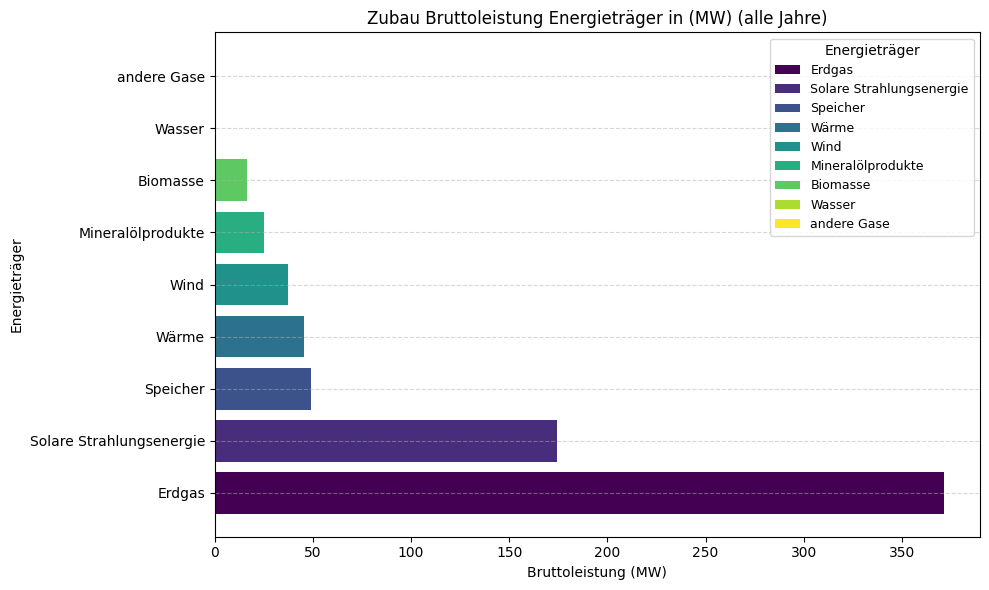

In [18]:
# Funktion Mainloop

root.mainloop()